Simple simulation
==

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

In [1]:
import mushi
import mushi.composition as cmp

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.special import expit
import stdpopsim

### Time grid

In [2]:
change_points = np.logspace(0, np.log10(100000), 100)
t = np.concatenate((np.array([0]), change_points))

### Define true demographic history

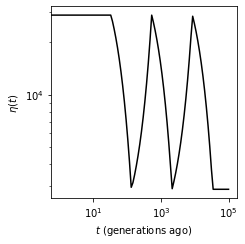

In [3]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = mushi.eta(change_points,
                     1 / ddb.coalescence_rate_trajectory(steps=t,
                                                         num_samples=[2],
                                                         double_step_validation=False)[0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k');

### Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

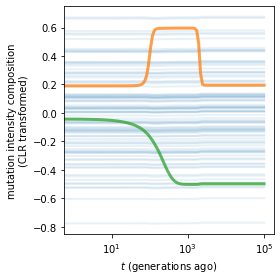

In [4]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
cols = 96
Z = np.zeros((len(t), cols))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, cols):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

mu_true = mushi.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, cols), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True);

Estimate the total mutation rate using $t=0$

In [5]:
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


## Simulate a $k$-SFS
- We'll sample 200 haplotypes
- note that this simulation will have a slightly varying total mutation rate, due to the pulse

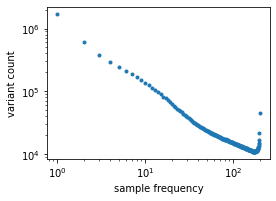

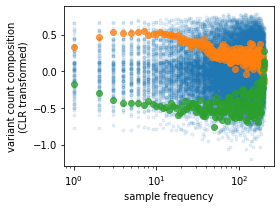

In [6]:
n = 200
ksfs = mushi.kSFS(n=n)
ksfs.simulate(eta_true, mu_true, r=0.02, seed=1)

plt.figure(figsize=(4, 3))
ksfs.plot_total(kwargs=dict(ls='', marker='.'))
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(4, 3))
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', c='C0'))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C2'))

Number of segregating sites

In [7]:
ksfs.X.sum()

8245268

### TMRCA CDF

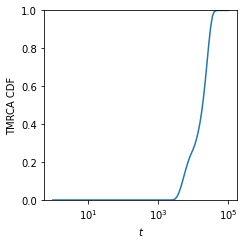

In [8]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(change_points, ksfs.tmrca_cdf(eta_true))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.tight_layout()

### Infer $\eta(t)$ and $\boldsymbol\mu(t)$

Run inference

folded = True
inferring η(t)
initial objective -9.177363e+07
iteration 1000, objective -9.184e+07, relative change 2.491e-10        
maximum iteration 1000 reached with relative change in objective function 2.5e-10


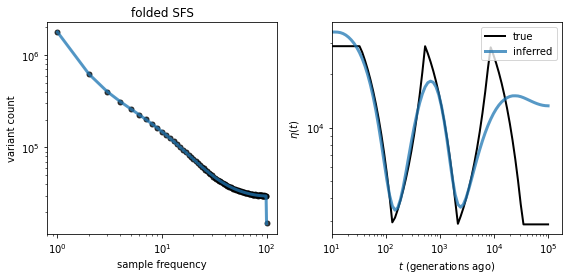

folded = False
inferring η(t)
initial objective -8.880245e+07
iteration 1000, objective -8.897e+07, relative change 2.368e-11        
maximum iteration 1000 reached with relative change in objective function 2.4e-11
inferred ancestral misidentification rate: 0.020


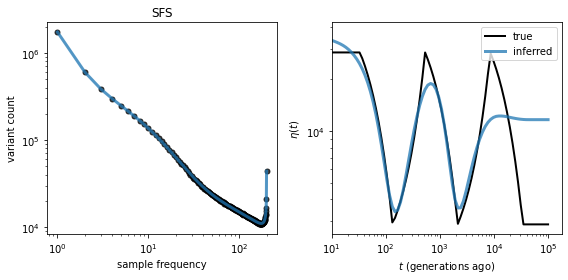

In [11]:
for folded in (True, False):
    print(f'folded = {folded}')
    ksfs.clear_eta()
    ksfs.clear_mu()
    ksfs.r = None

    # define regularization parameters and convergence criteria
    convergence = dict(tol=0, max_iter=1000)
    regularization_eta = dict(alpha_tv=2e0, alpha_spline=1e3, alpha_ridge=1e-4)

    ksfs.infer_history(change_points, mu0, infer_mu=False,
                       **regularization_eta, **convergence, verbose=True, folded=folded)
    if ksfs.r is not None:
        print(f'inferred ancestral misidentification rate: {ksfs.r:.3f}')
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                    line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                    fill_kwargs=dict(color='C0', alpha=0.1),
                    folded=folded)
    plt.xscale('log')
    plt.yscale('log')
    if folded:
        plt.title('folded SFS')
    else:
        plt.title('SFS')
    plt.subplot(122)
    eta_true.plot(c='k', lw=2, label='true')
    ksfs.eta.plot(lw=3, alpha=0.75, label='inferred')
    plt.xlim(1e1, None)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
ksfs.clear_mu()

# define regularization parameters and convergence criteria
regularization_mu = dict(hard=True, beta_rank=1e2, beta_tv=3e1, beta_spline=3e2, beta_ridge=1e-4)
convergence = dict(tol=0, max_iter=1000)

ksfs.infer_history(change_points, mu0, infer_eta=False,
                   **regularization_mu, **convergence, verbose=True)

plt.figure(figsize=(9, 3))

plt.subplot(131)
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', ms=5, mfc='none', c='C0', rasterized=True),
          line_kwargs=dict(alpha=0.1, lw=1, c='C0', rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C1'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C2'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C2'))

plt.subplot(132)
mu_true.plot(range(2, cols), alpha=0.1, lw=2, c='C0', clr=True, rasterized=True)
ksfs.mu.plot(range(2, cols), alpha=0.1, lw=3, ls='--', c='C0', clr=True, rasterized=True)
mu_true.plot((0,), alpha=0.75, lw=2, c='C1', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=3, ls='--', c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=2, c='C2', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=3, ls='--', c='C2', clr=True)

plt.subplot(133)
σ = np.linalg.svd(cmp.ilr(ksfs.mu.Z), compute_uv=False)
x = np.arange(1, len(σ) + 1)
plt.scatter(x, σ)
plt.plot(x, σ, 'ko', ms=5, mfc='none', mew=.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('singular value rank')
plt.ylabel('singular value')
plt.tight_layout()

inferring μ(t) conditioned on η(t)


TypeError: prf() takes 2 positional arguments but 3 were given